In [1]:
# !pip install pyg_lib torch_scatter torch_cluster torch-sparse torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch_geometric
!pip install "pandas<2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [3]:
import geopandas as gpd
from torch_geometric.data import HeteroData
import pandas as pd
import numpy as np
import torch
import pickle
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import math
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/MH_proc.pkl', "rb") as f:
    MH = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Road_proc.pkl', "rb") as f:
    Road = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/MH_R_RL_proc.pkl', "rb") as f:
    MH_R_RL = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Line_proc.pkl', "rb") as f:
    Line = pickle.load(f)
# with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/MH_MH_proc.pkl', "rb") as f:
#     MH_MH_RL = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/R_R_proc.pkl', "rb") as f:
    R_R_RL = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/split_mask.pkl', "rb") as f:
    split = pickle.load(f)

In [ ]:
len(MH), len(Road), len(Line)

(206187, 32080, 203203)

In [4]:
%cd /content/drive/MyDrive/0Network_PipeLine_Predcition
from Module.LocationEncoder import TheoryGridCellSpatialRelationEncoder

location_encoder = TheoryGridCellSpatialRelationEncoder(spa_embed_dim = 128, device = 'cuda')

/content/drive/MyDrive/0Network_PipeLine_Predcition


In [ ]:
len(np.unique(MH['SUBTYPECD'].values))

22

In [ ]:
train_set = set.union(*split['train'])
val_set = set.union(*split['val'])
test_set = set.union(*split['test'])

In [ ]:
from Module.dataset import dataset
train_data, train_line_index = dataset(MH, Line, Road, MH_R_RL, R_R_RL, train_set)
val_data, val_line_index = dataset(MH, Line, Road, MH_R_RL, R_R_RL, val_set)
test_data, test_line_index = dataset(MH, Line, Road, MH_R_RL, R_R_RL, test_set)

In [ ]:
import pickle

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/train_data.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(train_data, file)

    # Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/val_data.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(val_data, file)

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/test_data.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(test_data, file)

In [ ]:
import pickle

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/train_data.pkl', 'rb') as file:

    # A new file will be created
    train_data = pickle.load(file)

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/val_data.pkl', 'rb') as file:

    # A new file will be created
    val_data = pickle.load(file)

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/test_data.pkl', 'rb') as file:

    # A new file will be created
    test_data = pickle.load(file)

In [ ]:
train_data

HeteroData(
  MH={
    node_id=[127257],
    x=[127257, 24],
  },
  Road={
    node_id=[20506],
    x=[20506, 22],
  },
  (Road, link, Road)={ edge_index=[2, 59718] },
  (MH, near, Road)={
    edge_index=[2, 95049],
    edge_attr=[95049, 7],
  },
  (Road, rev_near, MH)={
    edge_index=[2, 95049],
    edge_attr=[95049, 7],
  },
  (MH, link, MH)={
    edge_index=[2, 251210],
    edge_label_index=[2, 251210],
    edge_label=[251210],
  }
)

In [ ]:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data['MH','link','MH'].edge_label_index
edge_label = train_data['MH','link','MH'].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[10, 20],
    neg_sampling_ratio=0,
    edge_label_index=(('MH','link','MH'), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Define the validation seed edges:
edge_label_index = val_data["MH", "link", "MH"].edge_label_index
edge_label = val_data["MH", "link", "MH"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20,10],
    edge_label_index=(("MH", "link", "MH"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=False,
)

# Define the testing seed edges:
edge_label_index = test_data["MH", "link", "MH"].edge_label_index
edge_label = test_data["MH", "link", "MH"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("MH", "link", "MH"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)
testing_data = next(iter(test_loader))

In [ ]:
def print_metrics(f1, precision, recall, mcc, accuracy):
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero, GATConv, HeteroConv, Linear
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.data import HeteroData


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, dropout = dropout, add_self_loops = False)
        # self.lin1 = Linear(-1, hidden_channels)
        # self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        # self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, dropout = dropout, add_self_loops = False)
        # self.lin2 = Linear(-1, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        # self.conv1 = SAGEConv(-1, hidden_channels)
        # self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        # self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        # self.conv4 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        # x = F.relu(self.conv1(x, edge_index, edge_attr) + self.lin1(x))
        # x = F.relu(self.conv2(x, edge_index))
        # x = F.relu(self.conv3(x, edge_index))
        # x = F.relu(self.conv4(x, edge_index, edge_attr) + self.lin2(x))
        # x = F.relu(self.conv5(x, edge_index))
        # x = self.conv6(x, edge_index)
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)
        return x
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_MH: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_line1 = x_MH[edge_label_index[0]]
        edge_feat_line2 = x_MH[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_line1 * edge_feat_line2).sum(axis = -1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels,dropout):
        super().__init__()
        # Instantiate homogeneous GNN:
        self.linear = torch.nn.Linear(96, hidden_channels)
        self.gnn = GNN(hidden_channels, dropout)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=train_data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        # `x_dict` holds feature matrices of all node types
        center = torch.mean(torch.concat([data.x_dict["MH"][:,:2], data.x_dict["Road"][:,:2]]), axis = 0)
        disp = {
            "MH": location_encoder((data.x_dict["MH"][:,:2] - center).reshape(-1, 1, 2)).reshape(-1, 96),
            "Road": location_encoder((data.x_dict["Road"][:,:2] - center).reshape(-1, 1, 2)).reshape(-1, 96),
            }
        x_dict = {
        "MH": torch.concat([F.relu(self.linear(disp["MH"])), data.x_dict["MH"][:,2:]], axis = 1),
        "Road": torch.concat([F.relu(self.linear(disp["Road"])),data.x_dict["Road"][:,2:]], axis = 1),
        }
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        pred = self.classifier(
            x_dict["MH"],
            data["MH", "link", "MH"].edge_label_index,
        )
        return pred


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
import tqdm
import torch.nn.functional as F
import pyg_lib
import torch_sparse
import csv
from itertools import product
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, matthews_corrcoef

# Define the CSV file where the metrics will be saved
csv_file_path = 'model_metrics.csv'

# Open the CSV file in write mode
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['Model Size', 'Dropout', 'Phase', 'Epochs', 'Training Loss', 'Validation Loss', 'AUC', 'F1', 'Precision', 'Recall', 'Accuracy', 'MCC'])
    sizes = [32, 64, 128, 256]
    dropouts = [0]
    for size, dropout in product(sizes, dropouts):
        model = Model(hidden_channels=size, dropout = dropout)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Device: '{device}'")
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=5, delta=0.001)
        loss_train = []
        loss_val = []
        for epoch in range(100):
            total_loss_train = total_examples_train = 0
            total_loss_val = total_examples_val = 0
            for train_samples in tqdm.tqdm(train_loader):
                optimizer.zero_grad()
                train_samples.to(device)
                train_pred = model(train_samples)
                train_ground_truth = train_samples["MH", "link", "MH"].edge_label
                train_loss = F.binary_cross_entropy_with_logits(train_pred, train_ground_truth)
                train_loss.backward()
                optimizer.step()
                total_loss_train += float(train_loss) * train_pred.numel()
                total_examples_train += train_pred.numel()
            for val_samples in tqdm.tqdm(val_loader):
                val_samples.to(device)
                val_pred = model(val_samples)
                val_ground_truth = val_samples["MH", "link", "MH"].edge_label
                val_loss = F.binary_cross_entropy_with_logits(val_pred, val_ground_truth)
                total_loss_val += float(val_loss) * val_pred.numel()
                total_examples_val += val_pred.numel()
            loss_train.append(total_loss_train / total_examples_train)
            loss_val.append(total_loss_val / total_examples_val)
            print(f"Epoch: {epoch+1:03d}, Training Loss: {loss_train[-1]}")
            print(f"Epoch: {epoch+1:03d}, Validation Loss: {loss_val[-1]}")
            early_stopping(loss_val[-1], model)
            if early_stopping.early_stop:
                print(f"Early stopping triggered after {epoch + 1} epochs!")
                break  # Break out of the loop if early stopping is triggered

        model.load_state_dict(torch.load('checkpoint.pt'))
        sampled_data = next(iter(train_loader))
        preds = []
        ground_truths = []
        for sampled_data in tqdm.tqdm(train_loader):
            with torch.no_grad():
                sampled_data.to(device)
                preds.append(model(sampled_data))
                ground_truths.append(sampled_data["MH", "link", "MH"].edge_label)
        pred = torch.cat(preds, dim=0).cpu().numpy()
        ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
        auc = roc_auc_score(ground_truth, pred)
        pred = (pred > 0.5) * 1
        f1 = f1_score(ground_truth, pred)
        precision = precision_score(ground_truth, pred)
        recall = recall_score(ground_truth, pred)
        accuracy = accuracy_score(ground_truth, pred)
        mcc = matthews_corrcoef(ground_truth, pred)

        print()
        print(f"Training AUC: {auc:.4f}")
        print_metrics(f1, precision, recall, mcc, accuracy)
        writer.writerow([size, dropout, 'Training', epoch - 4, loss_train[-6], loss_val[-6], auc, f1, precision, recall, accuracy, mcc])

        preds = []
        ground_truths = []
        model = model.to(device)
        for sampled_data in tqdm.tqdm(val_loader):
            with torch.no_grad():
                sampled_data.to(device)
                preds.append(model(sampled_data))
                ground_truths.append(sampled_data["MH", "link", "MH"].edge_label)
        pred = torch.cat(preds, dim=0).cpu().numpy()
        ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
        auc = roc_auc_score(ground_truth, pred)

        pred = (pred > 0.5) * 1
        f1 = f1_score(ground_truth, pred)
        precision = precision_score(ground_truth, pred)
        recall = recall_score(ground_truth, pred)
        accuracy = accuracy_score(ground_truth, pred)
        mcc = matthews_corrcoef(ground_truth, pred)

        print()
        print(f"Validation AUC: {auc:.4f}")
        print_metrics(f1, precision, recall, mcc, accuracy)
        torch.save(model.state_dict(), '/content/drive/MyDrive/0Network_PipeLine_Predcition/Models/model22_hiddensize_{}_drop_{:02d}.pt'.format(size, int(dropout*10)))
        writer.writerow([size, dropout, 'Validation', epoch + 1, loss_train[-6], loss_val[-6], auc, f1, precision, recall, accuracy, mcc])

        preds = []
        device = 'cuda'
        model = model.to(device)
        ground_truths = []
        for testing_data in tqdm.tqdm(test_loader):
            with torch.no_grad():
                testing_data.to(device)
                preds.append(model(testing_data))
                ground_truths.append(testing_data["MH", "link", "MH"].edge_label)
        pred = torch.cat(preds, dim=0).cpu().numpy()
        ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
        auc = roc_auc_score(ground_truth, pred)

        pred = (pred > 0.5) * 1
        f1 = f1_score(ground_truth, pred)
        precision = precision_score(ground_truth, pred)
        recall = recall_score(ground_truth, pred)
        accuracy = accuracy_score(ground_truth, pred)
        mcc = matthews_corrcoef(ground_truth, pred)

        print()
        print(f"Testing AUC: {auc:.4f}")
        print_metrics(f1, precision, recall, mcc, accuracy)
        writer.writerow([size, dropout, 'Testing', epoch + 1, loss_train[-6], loss_val[-6], auc, f1, precision, recall, accuracy, mcc])

Device: 'cuda'


100%|██████████| 534/534 [00:10<00:00, 48.65it/s]


Epoch: 001, Training Loss: 0.34082190767551296
Epoch: 001, Validation Loss: 0.3190092887390096


100%|██████████| 534/534 [00:11<00:00, 47.43it/s]


Epoch: 002, Training Loss: 0.2690155709978618
Epoch: 002, Validation Loss: 0.29983902813935975


100%|██████████| 534/534 [00:11<00:00, 47.96it/s]


Epoch: 003, Training Loss: 0.2567765133241456
Epoch: 003, Validation Loss: 0.29805122351968266


100%|██████████| 534/534 [00:11<00:00, 47.69it/s]


Epoch: 004, Training Loss: 0.2499324830865013
Epoch: 004, Validation Loss: 0.28444099096808023


100%|██████████| 534/534 [00:11<00:00, 46.32it/s]


Epoch: 005, Training Loss: 0.2438970141459883
Epoch: 005, Validation Loss: 0.29157841616900626
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 47.10it/s]


Epoch: 006, Training Loss: 0.24081015088389995
Epoch: 006, Validation Loss: 0.284186833869202
EarlyStopping counter: 2 out of 5


100%|██████████| 534/534 [00:11<00:00, 47.08it/s]


Epoch: 007, Training Loss: 0.23747783575281142
Epoch: 007, Validation Loss: 0.28153403102563906


100%|██████████| 534/534 [00:11<00:00, 44.66it/s]


Epoch: 008, Training Loss: 0.2348131918582379
Epoch: 008, Validation Loss: 0.27721078173220276


100%|██████████| 534/534 [00:11<00:00, 47.21it/s]


Epoch: 009, Training Loss: 0.23239234701052494
Epoch: 009, Validation Loss: 0.283571601816531
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 47.12it/s]


Epoch: 010, Training Loss: 0.23063693679139474
Epoch: 010, Validation Loss: 0.27613173679088115


100%|██████████| 534/534 [00:11<00:00, 45.64it/s]


Epoch: 011, Training Loss: 0.22884292314796978
Epoch: 011, Validation Loss: 0.2799938216362504
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.47it/s]


Epoch: 012, Training Loss: 0.2272945587265706
Epoch: 012, Validation Loss: 0.28058566394143236
EarlyStopping counter: 2 out of 5


100%|██████████| 534/534 [00:11<00:00, 47.81it/s]


Epoch: 013, Training Loss: 0.2256071166318153
Epoch: 013, Validation Loss: 0.2807047080920283
EarlyStopping counter: 3 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.42it/s]


Epoch: 014, Training Loss: 0.22392430552124717
Epoch: 014, Validation Loss: 0.27666982694625847
EarlyStopping counter: 4 out of 5


100%|██████████| 534/534 [00:11<00:00, 47.82it/s]


Epoch: 015, Training Loss: 0.2232719114184156
Epoch: 015, Validation Loss: 0.2796903611594422
EarlyStopping counter: 5 out of 5
Early stopping triggered after 15 epochs!


100%|██████████| 1963/1963 [00:38<00:00, 51.63it/s]



Training AUC: 0.9670
F1 Score: 0.9086
Precision: 0.9334
Recall: 0.8851
Matthews Correlation Coefficient (MCC): 0.8231
Accuracy: 0.9110


100%|██████████| 534/534 [00:10<00:00, 52.90it/s]



Validation AUC: 0.9530
F1 Score: 0.8934
Precision: 0.9063
Recall: 0.8809
Matthews Correlation Coefficient (MCC): 0.7901
Accuracy: 0.8949


100%|██████████| 227/227 [00:05<00:00, 41.10it/s]



Testing AUC: 0.9402
F1 Score: 0.8790
Precision: 0.8681
Recall: 0.8902
Matthews Correlation Coefficient (MCC): 0.7552
Accuracy: 0.8775
Device: 'cuda'


100%|██████████| 534/534 [00:12<00:00, 43.87it/s]


Epoch: 001, Training Loss: 0.32368604117702
Epoch: 001, Validation Loss: 0.32499668973094203


100%|██████████| 534/534 [00:11<00:00, 47.06it/s]


Epoch: 002, Training Loss: 0.25939627456279696
Epoch: 002, Validation Loss: 0.289288106041421


100%|██████████| 534/534 [00:11<00:00, 46.41it/s]


Epoch: 003, Training Loss: 0.24812505878097407
Epoch: 003, Validation Loss: 0.29478436861185014
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.89it/s]


Epoch: 004, Training Loss: 0.241191967295861
Epoch: 004, Validation Loss: 0.2954652519999854
EarlyStopping counter: 2 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.65it/s]


Epoch: 005, Training Loss: 0.2362023309872214
Epoch: 005, Validation Loss: 0.2725643570698679


100%|██████████| 534/534 [00:11<00:00, 46.87it/s]


Epoch: 006, Training Loss: 0.23207691041088624
Epoch: 006, Validation Loss: 0.2784693951367946
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 45.84it/s]


Epoch: 007, Training Loss: 0.2271870050271296
Epoch: 007, Validation Loss: 0.2738530229957585
EarlyStopping counter: 2 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.54it/s]


Epoch: 008, Training Loss: 0.22499309906862153
Epoch: 008, Validation Loss: 0.27649573553226314
EarlyStopping counter: 3 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.24it/s]


Epoch: 009, Training Loss: 0.22146964961935636
Epoch: 009, Validation Loss: 0.2849009340454373
EarlyStopping counter: 4 out of 5


100%|██████████| 534/534 [00:11<00:00, 45.40it/s]


Epoch: 010, Training Loss: 0.21866646459499006
Epoch: 010, Validation Loss: 0.2763320734703448
EarlyStopping counter: 5 out of 5
Early stopping triggered after 10 epochs!


100%|██████████| 1963/1963 [00:39<00:00, 50.10it/s]



Training AUC: 0.9681
F1 Score: 0.9092
Precision: 0.9287
Recall: 0.8905
Matthews Correlation Coefficient (MCC): 0.8229
Accuracy: 0.9111


100%|██████████| 534/534 [00:10<00:00, 51.80it/s]



Validation AUC: 0.9546
F1 Score: 0.8944
Precision: 0.9025
Recall: 0.8865
Matthews Correlation Coefficient (MCC): 0.7908
Accuracy: 0.8953


100%|██████████| 227/227 [00:05<00:00, 39.51it/s]



Testing AUC: 0.9409
F1 Score: 0.8790
Precision: 0.8653
Recall: 0.8932
Matthews Correlation Coefficient (MCC): 0.7545
Accuracy: 0.8771
Device: 'cuda'


100%|██████████| 534/534 [00:12<00:00, 44.02it/s]


Epoch: 001, Training Loss: 0.3259781413093248
Epoch: 001, Validation Loss: 0.32027416501892064


100%|██████████| 534/534 [00:11<00:00, 46.20it/s]


Epoch: 002, Training Loss: 0.26418486764579124
Epoch: 002, Validation Loss: 0.30161849799273266


100%|██████████| 534/534 [00:11<00:00, 46.24it/s]


Epoch: 003, Training Loss: 0.2521892928286678
Epoch: 003, Validation Loss: 0.28728761626960647


100%|██████████| 534/534 [00:11<00:00, 46.62it/s]


Epoch: 004, Training Loss: 0.24490415558536846
Epoch: 004, Validation Loss: 0.305665639156945
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 47.36it/s]


Epoch: 005, Training Loss: 0.23834748457423252
Epoch: 005, Validation Loss: 0.2797169533511829


100%|██████████| 534/534 [00:11<00:00, 46.39it/s]


Epoch: 006, Training Loss: 0.23404763969498904
Epoch: 006, Validation Loss: 0.280118745817734
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.57it/s]


Epoch: 007, Training Loss: 0.22905215695296666
Epoch: 007, Validation Loss: 0.28336952988796094
EarlyStopping counter: 2 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.42it/s]


Epoch: 008, Training Loss: 0.22521656040534202
Epoch: 008, Validation Loss: 0.2823542681855881
EarlyStopping counter: 3 out of 5


100%|██████████| 534/534 [00:11<00:00, 47.01it/s]


Epoch: 009, Training Loss: 0.22118779100440839
Epoch: 009, Validation Loss: 0.27920231059837397
EarlyStopping counter: 4 out of 5


100%|██████████| 534/534 [00:11<00:00, 45.81it/s]


Epoch: 010, Training Loss: 0.2175620500530043
Epoch: 010, Validation Loss: 0.2782696666353806


100%|██████████| 534/534 [00:11<00:00, 46.58it/s]


Epoch: 011, Training Loss: 0.21381019718819297
Epoch: 011, Validation Loss: 0.28599273278057963
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.03it/s]


Epoch: 012, Training Loss: 0.2114119028344116
Epoch: 012, Validation Loss: 0.27838917899966714
EarlyStopping counter: 2 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.17it/s]


Epoch: 013, Training Loss: 0.2079685012484686
Epoch: 013, Validation Loss: 0.2853336223305258
EarlyStopping counter: 3 out of 5


100%|██████████| 534/534 [00:11<00:00, 45.79it/s]


Epoch: 014, Training Loss: 0.20533740929936742
Epoch: 014, Validation Loss: 0.287822675988359
EarlyStopping counter: 4 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.94it/s]


Epoch: 015, Training Loss: 0.20181066357822489
Epoch: 015, Validation Loss: 0.28860174480674566
EarlyStopping counter: 5 out of 5
Early stopping triggered after 15 epochs!


100%|██████████| 1963/1963 [00:38<00:00, 50.64it/s]



Training AUC: 0.9731
F1 Score: 0.9145
Precision: 0.9332
Recall: 0.8966
Matthews Correlation Coefficient (MCC): 0.8330
Accuracy: 0.9162


100%|██████████| 534/534 [00:10<00:00, 51.97it/s]



Validation AUC: 0.9545
F1 Score: 0.8946
Precision: 0.9001
Recall: 0.8892
Matthews Correlation Coefficient (MCC): 0.7906
Accuracy: 0.8952


100%|██████████| 227/227 [00:05<00:00, 40.62it/s]



Testing AUC: 0.9427
F1 Score: 0.8797
Precision: 0.8632
Recall: 0.8968
Matthews Correlation Coefficient (MCC): 0.7552
Accuracy: 0.8773
Device: 'cuda'


100%|██████████| 534/534 [00:12<00:00, 43.33it/s]


Epoch: 001, Training Loss: 0.33378362163907893
Epoch: 001, Validation Loss: 0.33360741601345745


100%|██████████| 534/534 [00:11<00:00, 45.92it/s]


Epoch: 002, Training Loss: 0.2783319206945035
Epoch: 002, Validation Loss: 0.31774210938464575


100%|██████████| 534/534 [00:11<00:00, 45.43it/s]


Epoch: 003, Training Loss: 0.2641179244783543
Epoch: 003, Validation Loss: 0.30677937675757116


100%|██████████| 534/534 [00:11<00:00, 45.75it/s]


Epoch: 004, Training Loss: 0.25548443079801103
Epoch: 004, Validation Loss: 0.2918518544374384


100%|██████████| 534/534 [00:11<00:00, 45.60it/s]


Epoch: 005, Training Loss: 0.24859031042765933
Epoch: 005, Validation Loss: 0.2928048147132128
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 45.67it/s]


Epoch: 006, Training Loss: 0.24307363248681804
Epoch: 006, Validation Loss: 0.2951952948395984
EarlyStopping counter: 2 out of 5


100%|██████████| 534/534 [00:11<00:00, 45.91it/s]


Epoch: 007, Training Loss: 0.23806446408505608
Epoch: 007, Validation Loss: 0.29133403134260993
EarlyStopping counter: 3 out of 5


100%|██████████| 534/534 [00:11<00:00, 45.58it/s]


Epoch: 008, Training Loss: 0.2340735475237388
Epoch: 008, Validation Loss: 0.28506562840545563


100%|██████████| 534/534 [00:11<00:00, 45.43it/s]


Epoch: 009, Training Loss: 0.22986890578916724
Epoch: 009, Validation Loss: 0.28592243018471175
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 45.80it/s]


Epoch: 010, Training Loss: 0.22732190028509844
Epoch: 010, Validation Loss: 0.28766636714340726
EarlyStopping counter: 2 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.09it/s]


Epoch: 011, Training Loss: 0.22382103098680287
Epoch: 011, Validation Loss: 0.29498715815666976
EarlyStopping counter: 3 out of 5


100%|██████████| 534/534 [00:11<00:00, 45.93it/s]


Epoch: 012, Training Loss: 0.22065525313930828
Epoch: 012, Validation Loss: 0.28780459512580275
EarlyStopping counter: 4 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.20it/s]


Epoch: 013, Training Loss: 0.21772093548414612
Epoch: 013, Validation Loss: 0.28167013767842963


100%|██████████| 534/534 [00:11<00:00, 46.19it/s]


Epoch: 014, Training Loss: 0.21350851906190377
Epoch: 014, Validation Loss: 0.2964864376384889
EarlyStopping counter: 1 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.75it/s]


Epoch: 015, Training Loss: 0.21003422589761872
Epoch: 015, Validation Loss: 0.3022893492907383
EarlyStopping counter: 2 out of 5


100%|██████████| 534/534 [00:11<00:00, 47.19it/s]


Epoch: 016, Training Loss: 0.2074137457385068
Epoch: 016, Validation Loss: 0.2942134096534382
EarlyStopping counter: 3 out of 5


100%|██████████| 534/534 [00:11<00:00, 46.76it/s]


Epoch: 017, Training Loss: 0.2039465010363614
Epoch: 017, Validation Loss: 0.3000751008306455
EarlyStopping counter: 4 out of 5


100%|██████████| 534/534 [00:11<00:00, 47.39it/s]


Epoch: 018, Training Loss: 0.20045736010707443
Epoch: 018, Validation Loss: 0.3022418417883047
EarlyStopping counter: 5 out of 5
Early stopping triggered after 18 epochs!


100%|██████████| 1963/1963 [00:37<00:00, 51.75it/s]



Training AUC: 0.9740
F1 Score: 0.9170
Precision: 0.9262
Recall: 0.9080
Matthews Correlation Coefficient (MCC): 0.8357
Accuracy: 0.9178


100%|██████████| 534/534 [00:10<00:00, 52.26it/s]



Validation AUC: 0.9539
F1 Score: 0.8945
Precision: 0.8902
Recall: 0.8989
Matthews Correlation Coefficient (MCC): 0.7880
Accuracy: 0.8940


100%|██████████| 227/227 [00:05<00:00, 40.69it/s]



Testing AUC: 0.9434
F1 Score: 0.8807
Precision: 0.8517
Recall: 0.9117
Matthews Correlation Coefficient (MCC): 0.7548
Accuracy: 0.8764


In [ ]:
from torch_geometric.loader import LinkNeighborLoader
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, matthews_corrcoef
import tqdm
model.load_state_dict(torch.load('checkpoint.pt'))
sampled_data = next(iter(train_loader))
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(train_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["MH", "link", "MH"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
pred = (pred > 0.5) * 1
f1 = f1_score(ground_truth, pred)
precision = precision_score(ground_truth, pred)
recall = recall_score(ground_truth, pred)
accuracy = accuracy_score(ground_truth, pred)
mcc = matthews_corrcoef(ground_truth, pred)

print()
print(f"Training AUC: {auc:.4f}")
print_metrics(f1, precision, recall, mcc, accuracy)

In [ ]:
from torch_geometric.loader import LinkNeighborLoader
# Define the validation seed edges:
edge_label_index = val_data["MH", "link", "MH"].edge_label_index
edge_label = val_data["MH", "link", "MH"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20,10],
    edge_label_index=(("MH", "link", "MH"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=False,
)
# sampled_data = next(iter(val_loader))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import tqdm
preds = []
ground_truths = []
model = model.to(device)
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["MH", "link", "MH"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)

pred = (pred > 0.5) * 1
f1 = f1_score(ground_truth, pred)
precision = precision_score(ground_truth, pred)
recall = recall_score(ground_truth, pred)
accuracy = accuracy_score(ground_truth, pred)
mcc = matthews_corrcoef(ground_truth, pred)

print()
print(f"Validation AUC: {auc:.4f}")
print_metrics(f1, precision, recall, mcc, accuracy)
torch.save(model.state_dict(), '/content/drive/MyDrive/0Network_PipeLine_Predcition/Models/model22_hiddensize_256_drop_02.pt')

In [ ]:
# Define the testing seed edges:
edge_label_index = test_data["MH", "link", "MH"].edge_label_index
edge_label = test_data["MH", "link", "MH"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("MH", "link", "MH"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)
testing_data = next(iter(test_loader))

In [ ]:
from sklearn.metrics import roc_auc_score
import tqdm
preds = []
device = 'cuda'
model = model.to(device)
ground_truths = []
for testing_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        testing_data.to(device)
        preds.append(model(testing_data))
        ground_truths.append(testing_data["MH", "link", "MH"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)

pred = (pred > 0.5) * 1
f1 = f1_score(ground_truth, pred)
precision = precision_score(ground_truth, pred)
recall = recall_score(ground_truth, pred)
accuracy = accuracy_score(ground_truth, pred)
mcc = matthews_corrcoef(ground_truth, pred)

print()
print(f"Testing AUC: {auc:.4f}")
print_metrics(f1, precision, recall, mcc, accuracy)

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(ground_truth, pred)

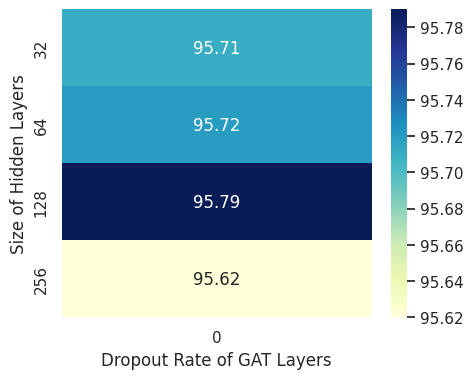

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from the table provided by the user
data_heat = {
    "0": [0.9571, 0.9572, 0.9579, 0.9562]
}

# Convert the dictionary to a pandas DataFrame and multiply by 100 to get percentages
df_percentage = pd.DataFrame(data_heat, index=[32, 64, 128, 256]) * 100

# Increase font size for the heatmap
sns.set(font_scale=1)

# Create the heatmap with the updated font size and percentage values
plt.figure(figsize=(5, 4))
ax = sns.heatmap(df_percentage, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)

# Set the labels for the axes with updated font size
ax.set_xlabel('Dropout Rate of GAT Layers')
ax.set_ylabel('Size of Hidden Layers')
# ax.set_title('ROC AUC Scores on Validation Data')

# Show the heatmap with larger font size
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/0Network_PipeLine_Predcition/Models/model_hiddensize_128_drop_0.pt'))

In [ ]:
!pip install captum
from torch_geometric.explain import Explainer, CaptumExplainer

class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model.to('cpu')

    def forward(self, x_dict, edge_index_dict, edge_attr, edge_label_index):
        # Convert x_dict and edge_index_dict to the format expected by the original model
        data = HeteroData()
        data['MH'].node_id = torch.arange(x_dict['MH'].shape[0])
        data['MH'].x = x_dict['MH']
        data['Road'].node_id = torch.arange(x_dict['Road'].shape[0])
        data['Road'].x = x_dict['Road']
        data['Road','link','Road'].edge_index = edge_index_dict['Road','link','Road']
        data['MH','near','Road'].edge_index = edge_index_dict['MH','near','Road']
        data['MH','near','Road'].edge_attr = edge_attr['MH','near','Road']
        data['Road','rev_near','MH'].edge_index = edge_index_dict['Road','rev_near','MH']
        data['Road','rev_near','MH'].edge_attr = edge_attr['Road','rev_near','MH']
        data['MH','link','MH'].edge_index = edge_index_dict['MH','link','MH']
        data['MH','link','MH'].edge_label_index = edge_label_index
        data = data.to('cpu')
        return self.model(data)

explainer = Explainer(
    ModelWrapper(model),  # It is assumed that model outputs a single tensor.
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type= 'attributes',
    edge_mask_type='object',
    model_config = dict(
        mode='binary_classification',
        task_level='edge',
        return_type='probs',  # Model returns probabilities.
    ),
)
# Generate batch-wise heterogeneous explanations for
# the nodes at index `1` and `3`:
hetero_explanation = explainer(
    test_data.x_dict,
    test_data.edge_index_dict,
    edge_attr =  test_data.edge_attr_dict,
    edge_label_index=test_data['MH','link','MH'].edge_index,
    index=torch.arange(test_data['MH', 'link', 'MH']['edge_index'].shape[1]),
)
print(hetero_explanation.edge_mask_dict)
print(hetero_explanation.node_mask_dict)

In [ ]:
hetero_explanation.node_mask_dict['MH'][4,:]

In [ ]:
pd.get_dummies(Road, columns = ['OVL2_CAT','angle_bin','len_bins']).iloc[:,6:]

In [ ]:
hetero_explanation.visualize_feature_importance(top_k= 10)

In [ ]:
test_data['Road'].x[:,8]

In [ ]:
Road

In [ ]:
hetero_explanation.get_explanation_subgraph()

In [ ]:
data.edge_attr_dict

In [ ]:
from captum.attr import IntegratedGradients
from torch_geometric.data import HeteroData

from torch_geometric.nn import (captum_output_to_dicts,
                                to_captum_model, to_captum_input)

class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x_dict, edge_index_dict, edge_attr, edge_label_index):
        # Convert x_dict and edge_index_dict to the format expected by the original model
        data = HeteroData()
        data['MH'].node_id = torch.arange(x_dict['MH'].shape[0])
        data['MH'].x = x_dict['MH']
        data['Road'].node_id = torch.arange(x_dict['Road'].shape[0])
        data['Road'].x = x_dict['Road']
        data['Road','link','Road'].edge_index = edge_index_dict['Road','link','Road']
        data['MH','near','Road'].edge_index = edge_index_dict['MH','near','Road']
        data['MH','near','Road'].edge_attr = edge_attr['MH','near','Road']
        data['Road','rev_near','MH'].edge_index = edge_index_dict['Road','rev_near','MH']
        data['Road','rev_near','MH'].edge_attr = edge_attr['Road','rev_near','MH']
        data['MH','link','MH'].edge_index = edge_index_dict['MH','link','MH']
        data['MH','link','MH'].edge_label_index = edge_label_index
        data = data.to('cpu')
        self.model = self.model.to('cpu')
        return self.model(data)

# Explain predictions for MH-MH edge `10`:
mask_type="edge"
metadata = test_data.metadata()
output_idx = 1
captum_model = to_captum_model(ModelWrapper(model), mask_type, output_idx, metadata)
inputs, additional_forward_args = to_captum_input(test_data.x_dict,
    test_data.edge_index_dict, mask_type,
    test_data.edge_attr_dict,
    test_data['MH','link','MH'].edge_index)

ig = IntegratedGradients(captum_model)
ig_attr = ig.attribute(inputs=inputs,
                       target=None,
                       additional_forward_args=additional_forward_args,
                       internal_batch_size=1)
edge_attr_dict = captum_output_to_dicts(ig_attr, mask_type, metadata)

In [ ]:
tensor = hetero_explanation.edge_mask_dict['MH', 'link', 'MH']
nonzero_values = tensor[torch.argmax(tensor)]
nonzero_indices = torch.argmax(tensor).squeeze()

nonzero_values, nonzero_indices


In [ ]:
val_data['MH','link','MH'].edge_index[:,25292]

In [ ]:
tensor = hetero_explanation.node_mask_dict['Road']
nonzero_values = tensor[np.unravel_index(torch.argmax(tensor),tensor.shape)]
nonzero_indices = np.unravel_index(torch.argmax(tensor),tensor.shape)

nonzero_values, nonzero_indices

In [ ]:
from fiona.crs import from_epsg
Line.iloc[train_line_index].crs = from_epsg(4326)
Line.iloc[train_line_index].to_file('train.shp')
Line.iloc[val_line_index].crs = from_epsg(4326)
Line.iloc[val_line_index].to_file('val.shp')
Line.iloc[test_line_index].crs = from_epsg(4326)
Line.iloc[test_line_index].to_file('test.shp')

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
f, ax = plt.subplots()
train_df = Line.iloc[train_line_index]
val_df = Line.iloc[val_line_index]
test_df = Line.iloc[test_line_index]
train_df['label'] ='train'
val_df['label'] ='val'
test_df['label'] ='test'
gdf = pd.concat([train_df, val_df, test_df])
colors = ['#FFD700', '#A13D3B', '#4169E1']
ax.set_facecolor('#f2ebe5')
custom_cmap = ListedColormap(colors)
gdf.plot(ax=ax, column='label', legend=True, cmap=custom_cmap)

In [ ]:
f, ax = plt.subplots()
ax.set_facecolor('#f2ebe5')
gdf.plot(ax=ax, column='label', cmap=custom_cmap, linewidth = 1)

ax.set(xlim=(153.05, 153.1), ylim=(-27.58, -27.53))
plt.gcf().set_size_inches(10, 8)

In [ ]:
f, ax = plt.subplots()
print(ax.get_xlim(), ax.get_ylim())
gdf.plot(ax=ax, column='label', legend=True, cmap='YlGnBu')
print(ax.get_xlim(), ax.get_ylim())

In [ ]:
Line.iloc[train_line_index].crs = from_epsg(4326)
Line.iloc[train_line_index].to_file('train.shp')

In [ ]:
# Define the testing seed edges:
edge_label_index = test_data["MH", "link", "MH"].edge_label_index
edge_label = test_data["MH", "link", "MH"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("MH", "link", "MH"), edge_label_index),
    edge_label=edge_label,
    batch_size=1,
    shuffle=False,
)
testing_data = next(iter(test_loader))

In [ ]:
model(testing_data.to('cpu'))

In [ ]:
from sklearn.metrics import roc_auc_score
import tqdm
preds = []
device = 'cuda'
model = model.to(device)
ground_truths = []
for testing_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        testing_data.to(device)
        preds.append(model(testing_data))
        ground_truths.append(testing_data["MH", "link", "MH"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Testing AUC: {auc:.4f}")